# Lab 9: Binary hypothesis testing, sequential hypothesis testing, and gambler's ruin

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.stats as st
from functools import reduce
print ('Modules Imported!')

Modules Imported!


## Binary Hypothesis Testing:

In this section we want to simulate the ML (maximum likelihood) rule for independent observations.  For simplicity, we consider two hyptheses for a sequence of $N$ independent discrete random variables, with values in {0, . . . , n-1}.  Let $p_0$ and $p_1$ be two probability vectors of length $n$, representing two probability distributions over the set of possible values {0,1, . . . ,n-1}.  Under hypothesis $H_1$ the observations are independent with pmf $p_1$ and under $H_0$ the observations are independent with pmf $p_0.$  The given code is for $p_0=[0.2,0.2,0.4,0.2]$ and $p_1=[0.4,0.3,0.2,0.1]$. 

In your ECE 313 class, you have used the likelihood ratio test (LRT) implementation of the ML rule to determine which hypothesis is most likely. Recall that the liklihood ratio for each observation $k$ is defined by: $$\Lambda(k) = \frac{p_1(k)}{p_0(k)}$$   For a single observaton $k$, under the ML rule, we declare Hypothesis 1 if $\Lambda(k)>1$ and declare Hypothesis 0 if $\Lambda(k)<1$.

In the code below, we want to be able to declare a hypothesis based on multiple observations. We can still use the LRT to determine which hypothesis to declare. This requires simply multiplying the likelihood ratios for the individual observations, to yield the likelihood ratio for all of the observations:
$$\Lambda(k_0,k_1,...k_{N-1})=\frac{p_1(k_0)}{p_0(k_0)}*\frac{p_1(k_1)}{p_0(k_1)}*...\frac{p_1(k_{N-1})}{p_0(k_{N-1})}$$

The code below creates two distributions (one for each hypothesis). It randomly chooses a hypothesis to be true and generates N random variates from that distribution. Finally, it computes $\Lambda$ and compares it to the threshold  one to declare (i.e. detect) a hypothesis.  Afterwards it evaluates whether an error, either a false alarm or miss, occurred.  Run the code a few times to see different outcomes.

In [9]:
N=10 # Number of samples
p0=np.array([0.2,0.2,0.4,0.2]) #Probability vector for H0
p1=np.array([0.4,0.3,0.2,0.1]) #Probability vector for H1

if np.size(p0)!=np.size(p1):
    print ("Warning, p0 and p1 have different sizes")

#Returns the ratio of the two probabilities for a single observation i
def f(i):
    return p1[i]/p0[i]

c=np.arange(np.size(p0)) #Random variables take values 0, 1, . . . , np.size(p0)-1
Xcstm0 = st.rv_discrete(values=(c,p0))   # scipy.stats object for distibution p0
Xcstm1 = st.rv_discrete(values=(c,p1))   # scipy.stats object for distibution p1

Htrue=np.random.randint(2)  # Sets the true hypothesis to be 0 or 1.

#Generates an array of variates under the true hypothesis
if Htrue==1:     
    variates = Xcstm1.rvs(size=N)   
else:
    variates = Xcstm0.rvs(size=N)
print ("Data generated using true hypothesis H",Htrue ,": ",variates)

#The next statement produces the likelihood ratio, Lamb, from the equation above.
#You may want to look up Python's lambda, reduce, and map functions for better understanding
Lamb = reduce(lambda x,y: x*y, map(f,variates))

#Determines which hypothesis to declare
if Lamb >= 1:
    print ("Lamb=", Lamb, ">=1; Declare H1")
else: print ("Lamb=", Lamb, "<1; Declare H0")

#Determines if our declaration was correct
if (Lamb >=1) and (Htrue==0):
    print ("H0 true, H1 declared -> False Alarm occured")
if (Lamb <1) and (Htrue==1):
    print ("H1 true, H0 declared -> Miss occured")


Data generated using true hypothesis H 1 :  [1 0 0 0 1 0 3 3 0 0]
Lamb= 35.99999999999999 >=1; Declare H1


<br>**<SPAN style="BACKGROUND-COLOR: #C0C0C0">Problem 1:</SPAN>** Answer the following questions using the given distributions for the hypotheses above:
<ol><li> Under these two hypothesis distributions, assume we are using the ML rule and one observation (i.e. N=1). What is the exact probability of a false alarm? What is the exact probability of a miss?</li>
<li> Run 10,000 simulations with the given hypothesis distributions where $N=1$ and H0 is true. Print out the simulated average false alarm probability.</li>
<li> Run 10,000 simulations with the given hypothesis distributions where $N=1$ and H1 is true. Print out the simulated average miss probability.</li>
<li> Do your simulated results agree with your theoretical results from part 1?</li>
<li> Repeat parts 2 and 3 but change the number of observations to $N=25$. This may take a little while to run. Does the increase in $N$ impact the error probabilities? Why do you think this may be the case?</li>

In [20]:
# Your code here (add additional code cells if necessary)
p0=np.array([0.2,0.2,0.4,0.2]) #Probability vector for H0
p1=np.array([0.4,0.3,0.2,0.1]) #Probability vector for H1
c=np.arange(np.size(p0)) #Random variables take values 0, 1, . . . , np.size(p0)-1
Xcstm0 = st.rv_discrete(values=(c,p0))   # scipy.stats object for distibution p0
Xcstm1 = st.rv_discrete(values=(c,p1))   # scipy.stats object for distibution p1

######################### part 2 #########################
print("------------------------- part 2 -------------------------")
cnt = 0
for _ in range(10000):
    variate = Xcstm0.rvs()
    lamb = f(variate)
    if lamb >= 1:
        cnt += 1
print("The simulated average false alarm probability is:", cnt/10000)

------------------------- part 2 -------------------------
The simulated average false alarm probability is: 0.3987


**<SPAN style="BACKGROUND-COLOR: #C0C0C0">End of Problem 1</SPAN>**

## Sequential Hypothesis Testing:

If we take a look at the values of the likelihood ratio produced by the simulations above for $N>1$, we see that sometimes the value is much larger than one or much smaller than one.  This suggests that even if we used fewer than all N observations we would have made the correct decision.   Other times the value of the likelihood ratio is close to one, suggesting it would be useful to take some additional observations.    The  idea of *sequential hypothesis testing* (originally developed by A. Wald in the 1940's--see his 1945 paper <A href=http://www.jstor.org/stable/2235829> "Sequential tests of statistical hypotheses"</A>) is to try to reduce the average number of observations required for the same error probabilities by using a variable number of observations.   Specifically, Wald's *sequential probability ratio test* (SPRT) works as follows. After each observation we compare the likelihood ratio obtained so far to two thresholds, A and B, where  0 < B < 1 < A.  If the likelihood ratio is smaller than B we stop taking samples and declare $H_0$ to be true.   If the likelihood ratio is larger than A we stop taking samples and declare $H_1$ to be true.   If the likelihood ratio is between the thresholds we take another observation. Below is an example of sequential hypothesis testing for the two hypotheses we had in the previous problem.

Data is generated using true hypothesis H 0 .
Lamb= 0.03515624999999999 < 0.055 ; Declare H0 is true
Number of Observations: 10


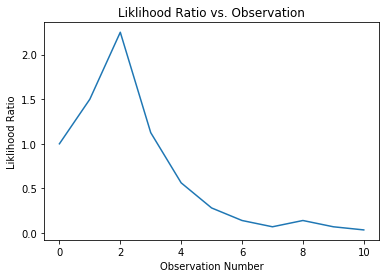

In [6]:
N_max=100 # maximum number of observations allowed
p0=np.array([0.2,0.2,0.4,0.2])
p1=np.array([0.4,0.3,0.2,0.1]) 

if np.size(p0)!=np.size(p1):
    print ("warning, p0 and p1 have different sizes")

def f(i):
    return p1[i]/p0[i]

c=np.arange(np.size(p0))
Xcstm0 = st.rv_discrete(values=(c,p0))   # scipy.stats object for distibution p0
Xcstm1 = st.rv_discrete(values=(c,p1))   # scipy.stats object for distibution p1

Htrue = np.random.randint(2)  # True hypothesis, should be 0 or 1

if Htrue==1:
    Xtrue = Xcstm1   
else:
    Xtrue = Xcstm0

t=0
Lamb=[1]
alpha =.06 # Upper bound on false alarm probability
beta=.055  # Upper bound on missed detection probability
A=1/alpha
B=beta

while (Lamb[t]>B) and (Lamb[t]<A) and (t<N_max):
    Lamb.append(f(Xtrue.rvs())*Lamb[t])
    t=t+1
    
print ("Data is generated using true hypothesis H",Htrue,".")

if Lamb[t] >= A:
    print ("Lamb=", Lamb[t], ">=",A,"; Declare H1 is true")
else: 
    print ("Lamb=", Lamb[t], "<",B,"; Declare H0 is true")

#Determines if our declaration was correct
if (Lamb[t] >=A) and (Htrue==0):
    print ("H0 true, H1 declared -> False alarm occured")
if (Lamb[t] <B) and (Htrue==1):
    print ("H1 true, H0 declared -> Miss occured")

plt.plot(Lamb)
plt.title('Liklihood Ratio vs. Observation')
plt.xlabel('Observation Number')
plt.ylabel('Liklihood Ratio')

print ('Number of Observations:', t)

Clearly, the probabilities of a false alarm or miss are dependent upon the values chosen for A and B. It can be shown that for given values $\alpha$ and $\beta$ between zero and one, we can ensure that $p_{false alarm}\leq\alpha$ and $p_{miss}\leq \beta$ by setting $A = \frac{1}{\alpha}$ and $B =\beta.$  This choice is on the conservative side.  Less conservative approximations for suitable thresholds (see p. 131 of Wald's paper) are given by $A = \frac{1-\beta}{\alpha}$ and $B =\frac{\beta}{1-\alpha}.$

When implementing likelihood ratios for large numbers of observations, the likelihood ratios can get extremely small (close to zero) or large.  An equivalent implementation that is numerically more stable
is to work with the logarithms of the likelihood ratios.   Instead of multiplying likelihood ratios as we did above, we can add log likelihood ratios using the update rule $S_i = S_{i-1}+\log(\Lambda_i).$  If we stop taking observations when $S_i<\log(B)$ or $S_i>\log(A)$ the test is equivalent to the one without taking logs and using thresholds B and A.

<br>**<SPAN style="BACKGROUND-COLOR: #C0C0C0">Problem 2:</SPAN>** Use the same distributions we had in the first problem to answer the following questions. For the numerical values of $\alpha$ and $\beta$ in parts 1 and 2 below, use the probabilities $p_{false~alarm}$ and $p_{miss}$, respectively, that you obtained experimentally in the last part of Problem 1.  That way, you should obtain a sequential testing rule with error probabilities of each type smaller than those for the nonsquential method in Problem 1.
<ol><li>Using the code above, suppose we wanted $p_{false alarm}\leq \alpha$ and $p_{miss}\leq \beta$. Verify, in simulation, we can achieve this by using a sequential hypothesis ratio test where
$A=\frac{1}{\alpha}$ and $B=\beta.$  To do this, for Htrue=0 and Htrue=1, perform 10,000 simulations each and calculate the error probabilities. Keep track of the number of observations needed during each simulation and print out the average. </li>
<li> Repeat the same experiment as 1, but use the procedure given above where
$A = \frac{1-\beta}{\alpha}$ and $B =\frac{\beta}{1-\alpha}.$  </li>
<li> The idea behind sequential hypothesis testing is that when using these ratios as thresholds, we should need a smaller number of observations on average to determine a hypothesis with the given error probabilities. Compare the average number of steps needed between part one of this problem, part two of this problem, and the last part of Problem 1. Comment on the differences.</li>

In [ ]:
# Your code here (add additional code cells if necessary)

__Answer:__ (Your answer here)

**<SPAN style="BACKGROUND-COLOR: #C0C0C0">End of Problem 2</SPAN>**

## Gambler's Ruin:

A very popular problem in random walks is known as the gambler's ruin problem. You should recognize this as a more simplified version of that zombie simulation we did back in Lab 6. Suppose that you're a gambler and you have $k$ units of money. You think you're a pretty good gambler and tell yourself you will leave the casino as soon as you have accumulated a total of $b$ units money, for some $b$ with $b>k$.
However, if you run out of money you need to stop playing; we say you are ruined in that case.  You can place only one bet for one unit of money at a time and the outcomes of the bet's are independent of each other. With each bet you have a probability $p$ of increasing your total by one and a probability $1-p$ of decreasing your total by one.  You could do this, for example, by betting one unit of money on red at a
<a href=http://en.wikipedia.org/wiki/Roulette> US roulette wheel </a> (which has 18 red numbers, 18 black numbers, and two dark green numbers 0 and 00), $p=18/38.$   What's the probability you ruin yourself (have no money left) before walking out of the casino? 

To answer the question of probability requires a recurrence equation and we'll get to that in a little bit, but first let's just simulate this problem. It is essentially a random walk. We can create a discrete random variable object to store the distribution used for the outcome of each bet, and use random variates of the object to model the independent outcomes.  We stop our simulation when we've either lost all our money or reached our goal.

Sorry, you were ruined.   Better luck next time!


Text(0.5, 0, 'Number of Bets')

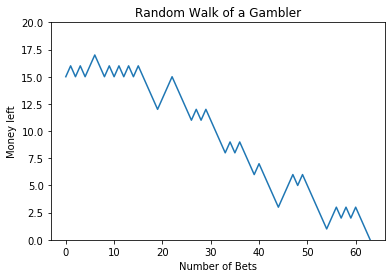

In [10]:
#Creates the RV of a bet
p = 18/38. #Probability of succeding in the bet
k = [15] #Starting amount of money
b = 20 #Monetary Goal
RVBet = st.rv_discrete(name='RVBet',values =([1,-1],[p,1-p]))

#Steps through the random walk until we either lose our money or meet the goal
n = 0
while (k[n]!=0 and k[n]!=b):
    k.append(k[n]+RVBet.rvs()) #Appends our current total plus the results of the bet
    n = n+1

if k[n]==b:
    print ("Congratulations, you made your goal!")
else:
    print ("Sorry, you were ruined.   Better luck next time!")
    
#Graphs the walk
n = range(n+1)
plt.plot(n,k)
plt.axis(ymin=0,ymax=b)
plt.title('Random Walk of a Gambler')
plt.ylabel('Money left')
plt.xlabel('Number of Bets')


Explore the gambler's ruin simulator if you want. For the given numbers ($p=18/38,b=20,$ initial stake 15) do you think the chance of success is greater than 50%?  Change the probabilities or the monetary values. What would you expect to happen if we had $p=\frac{1}{2}$? As stated before, in order to determine the probability of ruin, we need to set up a recurrence equation. Remember that the outcome for each bet placed is independent. 

Let $r_k$ represent the probability of ruin when we start with k units of money. 

Since the bets are independent we should see, by the law of total probability based on the outcome of the first bet, that $r_k=p*r_{k+1}+(1-p)*r_{k-1}.$   That is, the probability that we're ruined starting with $k$ units of money is equal to $p$ times the probability we're ruined starting with $k+1$ units of money plus $1-p$ times the probability we're ruined starting with $k-1$ units of money.  The boundary conditions are $r_0=1$ and $r_b=0,$ becasue if we have no money the probability we're ruined is 1, if we're at our goal, the probability we're ruined is 0). So we have $b-1$ equations for $b-1$ unknowns.

You may have seen such a set of linear equations in one of your math classes, but this recurrence has a closed form solution: $r_k=C_1\lambda_1^k+C_2\lambda_2^k$, where $\lambda_{1}$ and $\lambda_{2}$ solve the characteristic equation $\lambda=p\lambda^2+(1-p)$ which is derived from our recurrence equation. (A quick way to derive this characteristic equation from the recurrence equation is to replace $r_k$ with $\lambda^k$, $r_{k+1}$ with $\lambda^{k+1}$ and $r_{k-1}$ with $\lambda^{k-1}$, then cancel out $\lambda^{k-1}$ on both sides). To solve for the two constants $C_1$ and $C_2$, we use the two boundary conditions $r_0=1, r_b=0.$  

As an example let's use the initial conditions set up above where $b=20,k=15,p=\frac{18}{38}$. The first step is to find $\lambda$ from the recurrence equation: $0=p\lambda^2-\lambda+(1-p)$

In [11]:
p = 18./38 #probability
c = [p,-1,(1-p)]#Creates a vector of the coefficients of the quadratic equation
print (np.roots(c)) #Prints the roots of the polynomial with coefficients given by c

[1.11111111 1.        ]


With a little bit of theory, in our specific scenario, we could show that we will always get roots of 1 and $\frac{1-p}{p}.$  But this changes once our scenario differs from just the simple two option ruin problem shown here.  Let's let
$\lambda = \lambda_1 = \frac{1-p}{p}$ and
$\lambda_2=1,$  so we have $r_k=C_{1}\lambda^k+C_{2}.$ 

We can solve for the coefficients using the boundary conditions $r_0=1$ and $r_b=0$. We get:

$C_{1}+C_{2}=1$ and $C_{1}\lambda^{b}+C_{2}=0$.

So $C_1$ satisfies $C_1\lambda^{b}+(1-C_1)=0$,  or $C_1(\lambda^{b}-1)=-1$, or $C_1 = \frac{1}{1-\lambda^{b}},$  and $C_2 = 1-C_1.$  So the probability that we're ruined if we start with 15 dollars is computed by:


In [12]:
lamb=(1-p)/p
C1 = 1./(1-lamb**20)
C2 = 1-C1
print ('P{ruin when starting at 15}=',C1*lamb**15+C2)

P{ruin when starting at 15}= 0.4661875189680086


Your chance of success is better than 50%!  However, if you are successful you win only five units of money and if you are ruined you lose fifteen units of money.  

There is a connection between SPRTs and the gambler's ruin problem. For example, consider the following hypotheses for a sequence of independent binary observations:
<ul>
<li> H_0: The obervations have the Bernoulli distribution with parameter p=18/38.
<li> H_1: The observations have the Bernoulli distribution with parameter p=20/38.
</ul>
<br>**<SPAN style="BACKGROUND-COLOR: #C0C0C0">Problem 3:</SPAN>** (This is a thinking problem, not a coding problem.  You should thus write your answer in a markdown cell instead of writing code.)
<ol>
<li> Write down the sequence of likelihood ratios after 1,2,3,4, or 5 observations, for
the sequence of observations 1,1,0,1,1.  Express you answers as powers of (20/18).  (Note: You should be able to see that the sequence of likelihood ratios is determined by a random walk.)
<li> Find values of the thresholds $A$ and $B$ for the SPRT so that $1−p_{false~alarm}$ for the SPRT is equal to the probability the gambler is ruined for the roulette game (i.e. with win probability p=18/38 for each bet) simulated above with b=20 and inital state 15.  (Hint: Think about how the likelihood ratio for the SPRT changes after each observation to see where a random walk fits in.)
</ol>

__Answer:__ (Your answer here)

**<SPAN style="BACKGROUND-COLOR: #C0C0C0">End of Problem 3</SPAN>**

<br>**<SPAN style="BACKGROUND-COLOR: #C0C0C0">Problem 4:</SPAN>** Now, I want you to analyze a slightly more complext version of the gambler's ruin problem. Suppose that a gambler walks into a casino with 15 units of money and will leave if he meets his goal of 20 units of money or if he loses all of his money. For each bet, there is a probability of 0.4 that he wins one unit of money, a probability 0.15 that he breaks even (neither wins nor loses money), and a probability 0.45 that he loses one unit of money. 
<html>
    <body>
        <ol>
            <li> Create a single simulation of this gambler's ruin problem. Graph the gambler's progress over each bet.</li>
            <li> Use the process described above to determine the recurrence equation. It will be of the form $r_k = p_1r_{k+1} + p_2r_k+p_3r_{k-1}$, which has a closed form solution: $r_k=C_1\lambda_1^k+C_2\lambda_2^k$. What is the probability that a gambler is ruined when he starts with $15$ dollars?
            <li> Simulate the gambler's ruin problem 10,000 times starting with $15$ dollars. What is the experimental ruin probability? How does it compare to your answer in 2? (Hint: Don't print out the graph for each simulation, this is completely unnecessary and time consuming.)
        </ol>
    </body>
</html>

In [ ]:
# Your code here 

__Answer:__ (Your answer here)

**<SPAN style="BACKGROUND-COLOR: #C0C0C0">End of Problem 4</SPAN>**

## Lab Questions:

For this weeks lab, please answer all questions 1-4.

<div class="alert alert-block alert-warning"> 
## Academic Integrity Statement ##

By submitting the lab with this statement, you declare you have written up the lab entirely by yourself, including both code and markdown cells. You also agree that you should not share your code with anyone else. Any violation of the academic integrity requirement may cause an academic integrity report to be filed that could go into your student record. See <a href="https://provost.illinois.edu/policies/policies/academic-integrity/students-quick-reference-guide-to-academic-integrity/">Students' Quick Reference Guide to Academic Integrity</a> for more information. 